Se debe agregar la carpeta a analizar en el drive y acceder a la carpeta compartida a través de las siguientes líneas.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Constantes

Recuerda que debes cambiar las constantes a como tu lo necesites. (Si cambia el path de directorio o imagen a probar)

In [2]:
in_dir = '/content/drive/MyDrive/Fichas_auto_100'

In [64]:
path = "/content/drive/MyDrive/Ficheros_Detenidos_Desaparecidos_Morales_Lopez_Delia_Morales_Lopez_Delia-23-.JPG"

In [95]:
output_dir_path = "/content/drive/MyDrive"

## Importación de librerias importantes

In [4]:
!pip install "git+https://github.com/caroacostatovany/hackathon_RIIAA2021.git#egg=busquedadesaparecidos&subdirectory=src" --quiet

     |████████████████████████████████| 45.6 MB 44 kB/s 


In [5]:
!sudo apt install libleptonica-dev tesseract-ocr libtesseract-dev --quiet

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libleptonica-dev libtesseract-dev tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 5 newly installed, 0 to remove and 40 not upgraded.
Need to get 7,550 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libleptonica-dev amd64 1.75.3-3 [1,308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract-dev amd64 4.00~git2288-10f4998a-2 [1,447 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/

In [6]:
author = 'caroacostatovany'
repository = 'hackathon_RIIAA2021'
!git clone https://github.com/{author}/{repository}.git

Cloning into 'hackathon_RIIAA2021'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 208 (delta 106), reused 152 (delta 61), pack-reused 0
Receiving objects: 100% (208/208), 26.51 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [7]:
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
import pytesseract
import pandas as pd

from busquedadesaparecidos.ocr.procesamiento_imagen import escala_grises, eliminar_ruido
from busquedadesaparecidos.utils.limpieza_texto import quitar_caracteres_especiales, quitar_nonascii, quitar_stopwords, convierte_minusculas
from busquedadesaparecidos.ner.busqueda_expediente import encontrar_expediente, convertir_texto_exp_dataframe
from busquedadesaparecidos.ner.spacy import obtener_entidades, guardar_entidades_en_dataframe

# Importamos spacy y el modelo en español
import spacy
nlp = spacy.load("es_core_news_sm")

# Importamos el visualizador incluido en spacy
from spacy import displacy

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [8]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import timeit

Found GPU at: /device:GPU:0


In [9]:
%cd {repository}

/content/hackathon_RIIAA2021


# Lectura de un directorio

In [94]:
# import required module
import os
 
folder_list=os.listdir(in_dir)

reto_2b_mayus = pd.DataFrame()
reto_2b_minus = pd.DataFrame()
reto_2a = pd.DataFrame() 

for folders, sub_folders, file in os.walk(in_dir):
    for name in file:
        if name.lower().endswith((".jpg",".png",".jpeg")):
          path = "{}/{}".format(in_dir, name)
          print("="*100)
          print("Analizando archivo {}".format(path))
          print("Iniciando procesamiento de imagen")
          imagen_original = cv2.imread(path)
          gray_img = escala_grises(imagen_original)
          imagen_sin_ruido = eliminar_ruido(gray_img)
          im = Image.fromarray(imagen_sin_ruido)
          save_path = "gray.png"
          im.save(save_path)
          !python binarize/binarize.py -imgpath "{save_path}" -save out_test.png
          img = cv2.imread('out_test.png')
          kernel = np.ones((2, 2),np.uint8)
          closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
          dilation = cv2.erode(closing, kernel,iterations = 1)
          print("Procesamiento de imagen terminada")
          print("Iniciando OCR")
          texto_extraido = pytesseract.image_to_string(dilation)
          print("OCR terminado")
          if texto_extraido is None:
            print("No se encontró texto en {}".format(path))
          else:
            print("Iniciando limpieza de texto")
            texto_limpio = quitar_caracteres_especiales(texto_extraido)
            texto_limpio = quitar_nonascii(texto_limpio)
            texto_limpio = quitar_nonascii(texto_limpio)
            texto_limpio_minusculas = convierte_minusculas(texto_limpio)
            print("Limpieza de texto terminada")
            print("Iniciando búsqueda de expediente")
            exp = encontrar_expediente(texto_limpio_minusculas)
            print(exp)
            df_exp = convertir_texto_exp_dataframe(path, exp, texto_limpio_minusculas)
            reto_2a = pd.concat([reto_2a, df_exp])
            print("Búsqueda de expediente finalizada")
            
            print("Iniciando clasificación de entidades")
            doc_mayus = obtener_entidades(texto_limpio)
            df_mayus = guardar_entidades_en_dataframe(doc_mayus, path)
            reto_2b_mayus = pd.concat([reto_2b_mayus, df_mayus])

            doc_minus = obtener_entidades(texto_limpio_minusculas)
            df_minus = guardar_entidades_en_dataframe(doc_minus, path)
            reto_2b_minus = pd.concat([reto_2b_minus, df_minus])
            print("Clasificación de entidades finalizada")

reto_2a.to_csv("{}/reto_2a.csv".format(output_dir_path))
reto_2b_mayus.to_csv("{}/reto_2b_mayus.csv".format(output_dir_path))
reto_2b_minus.to_csv("{}/reto_2b_minus.csv".format(output_dir_path))



Analizando archivo /content/drive/MyDrive/Fichas_auto_100/Ficheros_Lucio_Cabanas_Barrientos_60-11-04_a_73-04-30_Lucio_Fichas-25-.JPG
Iniciando procesamiento de imagen
2021-08-22 19:14:14.633699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 19:14:14.643038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 19:14:14.643899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 19:14:15.133660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at le



---

Aquí termina lectura de directorio

---



# Lectura de una imagen (sin guardar output en csv)

In [65]:
# Leemos la imagen
imagen_original = cv2.imread(path)

# Procesamiento de imagen

In [66]:
gray_img = escala_grises(imagen_original)
imagen_sin_ruido = eliminar_ruido(gray_img)

In [67]:
im = Image.fromarray(imagen_sin_ruido)
save_path = "gray.png"
im.save(save_path)

In [68]:
!python binarize/binarize.py -imgpath "{save_path}" -save out_test.png

2021-08-22 19:12:27.541144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 19:12:27.554272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 19:12:27.555207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 19:12:28.046798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 19:12:28.047747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [69]:
img = cv2.imread('out_test.png')

In [70]:
kernel = np.ones((2, 2),np.uint8)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

In [71]:
dilation = cv2.erode(closing, kernel,iterations = 1)

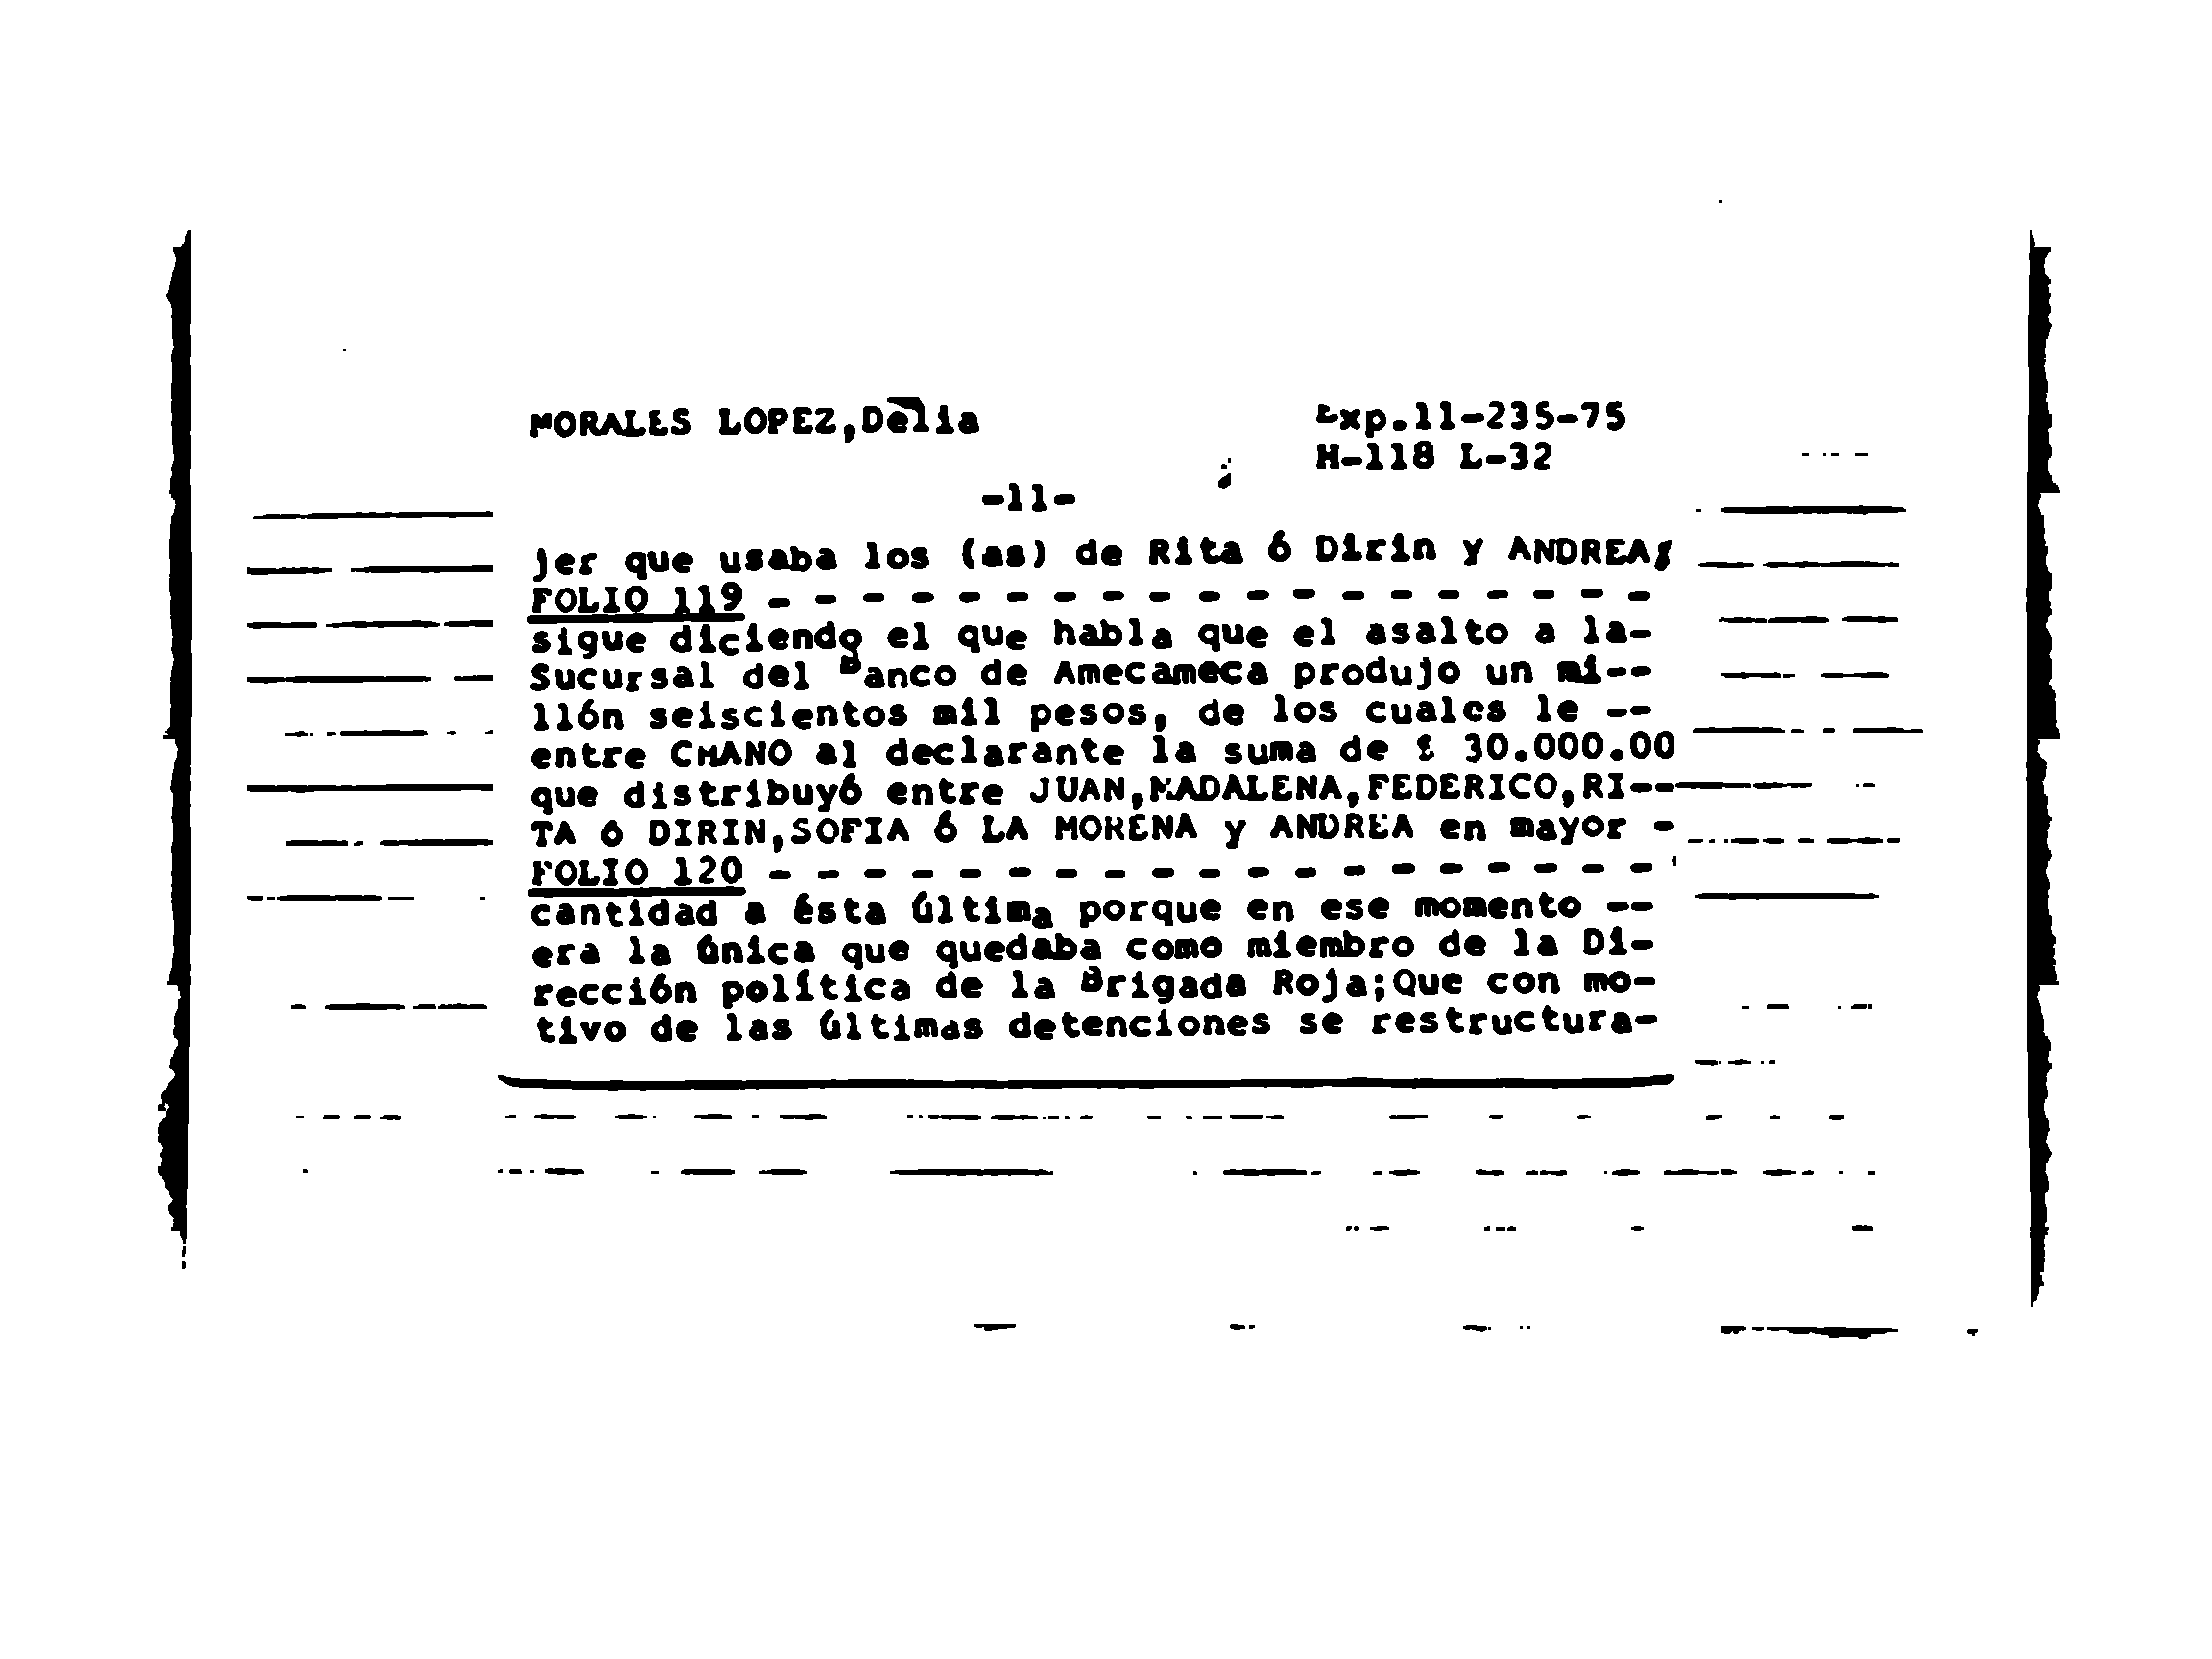

In [72]:
cv2_imshow(dilation)

# OCR 

In [79]:
texto_extraido = pytesseract.image_to_string(dilation)

In [80]:
texto_extraido

'-. -— - =\n\nMORALES LOPEZ,Délia &xp.1l-235<75\nj He118 L-32\n\njJec que usaba los (as) de Rita & Dirin y ANDREAs __\n\nFOLIO 119 -=-- ee ee ee ee ee ee ee ew\nsigue diciendg el que habla que el asalto a la-\nSucursal de] "anco de Amecameca produjo un ai--\nllén seiscientos mil pesos, de los cuales le -=-\n\nentre CHANO a] declarante la suma de £ 30.000.00\n\n—-—-\n\nque distribuyS entre JUAN, MADALENA, FEDERICO,RI--————— -\nTA © DIRIN,SOFIA & LA MORENA y ANDREA en mayor =_.__ _ __.\n\nFOLIO 120 = 8©= ese e= =e we eweeewnezeeeree\'\n\ncantidad @ ésta Gltima porque en ese momento --\n\nera la Gnica que quedaba como miembro de la Di-\nreccién politica de la Srigada Roja;Que con mo-\ntivo de las Gltimas detenciones se restructura-\n\n--—\n\x0c'

# Limpieza de texto

In [81]:
texto_limpio = quitar_caracteres_especiales(texto_extraido)
texto_limpio = quitar_nonascii(texto_limpio)
texto_limpio = quitar_nonascii(texto_limpio)

In [82]:
texto_limpio

'- - - MORALES LOPEZDelia &xp1l-23575j He118 L-32jJec que usaba los as de Rita & Dirin y ANDREAs FOLIO 119 --- ee ee ee ee ee ee ee ewsigue diciendg el que habla que el asalto a la-Sucursal de] "anco de Amecameca produjo un ai--llen seiscientos mil pesos de los cuales le --entre CHANO a] declarante la suma de  3000000--que distribuyS entre JUAN MADALENA FEDERICORI-- -TA  DIRINSOFIA & LA MORENA y ANDREA en mayor   FOLIO 120  8 ese e e we eweeewnezeeereecantidad  esta Gltima porque en ese momento --era la Gnica que quedaba como miembro de la Di-reccien politica de la Srigada RojaQue con mo-tivo de las Gltimas detenciones se restructura---\x0c'

In [83]:
texto_limpio_minusculas = convierte_minusculas(texto_limpio)

In [84]:
texto_limpio_minusculas

'- - - morales lopezdelia &xp1l-23575j he118 l-32jjec que usaba los as de rita & dirin y andreas folio 119 --- ee ee ee ee ee ee ee ewsigue diciendg el que habla que el asalto a la-sucursal de] "anco de amecameca produjo un ai--llen seiscientos mil pesos de los cuales le --entre chano a] declarante la suma de  3000000--que distribuys entre juan madalena federicori-- -ta  dirinsofia & la morena y andrea en mayor   folio 120  8 ese e e we eweeewnezeeereecantidad  esta gltima porque en ese momento --era la gnica que quedaba como miembro de la di-reccien politica de la srigada rojaque con mo-tivo de las gltimas detenciones se restructura---\x0c'

# EXP

In [85]:
x = encontrar_expediente(texto_limpio_minusculas)

In [86]:
df_exp = convertir_texto_exp_dataframe(path, x, texto_limpio_minusculas)

In [87]:
df_exp

,filename,text
0,/content/drive/MyDrive/Ficheros_Detenidos_Desa...,xp1| - - - morales lopezdelia &l-23575j he118 ...


# NER

## Texto utilizando mayus

In [88]:
doc = obtener_entidades(texto_limpio)

In [89]:
# Se muestran las entidades con el visualizador
for sent in doc.sents:
    displacy.render(nlp(sent.text),style='ent',jupyter=True)

/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [90]:
# Se extraen las entidades con su tipo
df_mayus = guardar_entidades_en_dataframe(doc, path)
df_mayus

,texto,clase,filename
0,MORALES LOPEZDelia &xp1l-23575j,ORG,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
1,L-32jJec que usaba los as,PRODUCT,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
2,de Rita & Dirin y,ORG,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
3,el que habla que el asalto,ORG,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
4,anco de Amecameca,WORK_OF_ART,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
5,seiscientos mil pesos,PERSON,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
6,declarante la suma de,PERSON,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
7,DIRINSOFIA & LA,ORG,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
8,ANDREA,PERSON,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
9,FOLIO,ORG,/content/drive/MyDrive/Ficheros_Detenidos_Desa...


## Texto todo en minusculas

In [91]:
doc = obtener_entidades(texto_limpio_minusculas)

In [92]:
# Se muestran las entidades con el visualizador
for sent in doc.sents:
    displacy.render(nlp(sent.text),style='ent',jupyter=True)

/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [93]:
# Se extraen las entidades con su tipo
df_minus = guardar_entidades_en_dataframe(doc, path)
df_minus

,texto,clase,filename
0,l-32jjec que usaba,PERSON,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
1,de rita & dirin y,ORG,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
2,el que habla que el asalto,ORG,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
3,anco de amecameca,WORK_OF_ART,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
4,seiscientos mil pesos,PERSON,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
5,declarante la suma de,PERSON,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
6,3000000,CARDINAL,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
7,entre juan madalena federicori-- -ta,PERSON,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
8,andrea,PERSON,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
9,120,CARDINAL,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
